In [1]:
from tg.grammar_ru import *
import os
import pandas as pd
import numpy as np
from yo_fluq_ds import *

FOLDER = Loc.data_cache_path/'Rowling'
os.makedirs(FOLDER,exist_ok=True)
db = DataBundle.load(FOLDER/'bundle.zip')
word_to_normal_form = db.words.set_index('word').nf_n.to_dict()

GLOVE = FOLDER/'glove'
vectors_file = GLOVE/'output.txt'
vdf = pd.read_csv(vectors_file, sep=' ',header=None).set_index(0)
vdf = vdf.reset_index(drop=True).iloc[:-1]
vdf.columns=list(range(vdf.shape[1]))
vdf.index.name='index'

In [2]:
from jordan_lib.preprocessing import array_to_tokens

def get_author_frames(author):
    def to_normal(word):
        try:
            return word_to_normal_form[word.lower()]
        except:
            return 1 if word == '-' else 0
    reader = CorpusReader(Loc.corpus_path/'books.featurized.zip')
    toc = reader.get_toc()
    toc = toc.loc[toc.author==author]
    files = toc.index
    return (reader
            .get_frames(files)
            .select(lambda x: x.word.apply(to_normal).to_frame().rename(columns={'word': 'id'})))

get_author_frames('Роулинг').first()

,id
0,16244
1,6158
2,9243
3,13698
4,2691
...,...
706,20303
707,0
708,10823
709,4478


In [3]:
from glove_helpers.prep import CoocSelector, MatrixCollector, VocabStatsCollector

NAMES = FOLDER/'names'
LEN = db.nfs.shape[0]
window_size = 15

cs = CoocSelector(window_size, LEN, True)
cl = MatrixCollector(LEN, NAMES/'matrix', 1000)

(get_author_frames('Роулинг')
     .feed(fluq.with_progress_bar())
     .select(cs.compute_cooc)
     .foreach(cl.observe))

  0%|          | 0/369 [00:00<?, ?it/s]

In [4]:
nz_indices = cl.matrix.nonzero()[0]
len(nz_indices)

3230164

In [5]:
cooc_pairs = pd.DataFrame({ 'pair_index': nz_indices })
cooc_pairs['nf_index'] = cooc_pairs['pair_index'] // LEN
cooc_pairs['context_nf_index'] = cooc_pairs['pair_index'] % LEN
cooc_pairs['co-occurrence'] = cl.matrix[cooc_pairs['pair_index']]
cooc_pairs['label'] = np.log(1 + cooc_pairs['co-occurrence'])
cooc_pairs

,pair_index,nf_index,context_nf_index,co-occurrence,label
0,0,0,0,228496.294397,12.339280
1,1,0,1,4.751923,1.749534
2,2,0,2,8635.891631,9.063798
3,3,0,3,2.267857,1.184134
4,4,0,4,0.877778,0.630089
...,...,...,...,...,...
3230159,431139240,20763,16308,0.083333,0.080043
3230160,431139567,20763,16635,0.342857,0.294800
3230161,431139614,20763,16682,0.377778,0.320472
3230162,431139723,20763,16791,0.333333,0.287682


In [6]:
common_cooc = cooc_pairs[['nf_index', 'context_nf_index', 'label']]
name_nfs = db.words[db.words['is_name']].nf_n.unique()
non_name_nfs = db.words[~db.words['is_name']].nf_n.unique()
name_in_nonname_context = (common_cooc[common_cooc['nf_index'].isin(name_nfs) & 
                                       common_cooc['context_nf_index'].isin(non_name_nfs)]
                           .rename(columns={'nf_index': 'trainable', 'context_nf_index': 'pretrained'}))
nonname_in_name_context = (common_cooc[common_cooc['nf_index'].isin(non_name_nfs) & 
                                       common_cooc['context_nf_index'].isin(name_nfs)]
                           .rename(columns={'nf_index': 'pretrained', 'context_nf_index': 'trainable'})
                           [['trainable', 'pretrained', 'label']])

In [10]:
from tg.common.ml import batched_training as bt
import torch

class GloVeNetwork(torch.nn.Module):
    def __init__(self, Wtrained: torch.Tensor, Btrained: torch.Tensor):
        super(GloVeNetwork, self).__init__()
        self.Wtrained = torch.nn.Embedding.from_pretrained(Wtrained)
        self.Btrained = torch.nn.Embedding.from_pretrained(Btrained)
        self.W = torch.nn.Embedding(num_embeddings=Wtrained.shape[0], embedding_dim=Wtrained.shape[1])
        self.b = torch.nn.Embedding(num_embeddings=Btrained.shape[0], embedding_dim=Btrained.shape[1])
        
    def forward(self, batch):
        Wtr = self.Wtrained(torch.LongTensor(batch['input'].pretrained.values))
        btr = self.Btrained(torch.LongTensor(batch['input'].pretrained.values))
        W = self.W(torch.LongTensor(batch['input'].trainable.values))
        b = self.b(torch.LongTensor(batch['input'].trainable.values))
        return torch.sum((Wtr * W), dim=1).unsqueeze(1) + btr + b 

def get_idb_network(df, w, bias):
    name_db = DataBundle(index_frame=df)
    name_idb = bt.IndexedDataBundle(
        index_frame = df,
        bundle = name_db
    )
    network = GloVeNetwork(torch.Tensor(w.values), torch.Tensor(bias.values).unsqueeze(1))
    return name_idb, network

In [11]:
w_c = vdf.iloc[:, 301:601].reset_index(drop=True)
bias_c = vdf.iloc[:, 601]

name_idb, network = get_idb_network(name_in_nonname_context, w_c, bias_c)

In [14]:
from tg.grammar_ru import DataBundle
from tqdm import tqdm

input_extractor = bt.PlainExtractor.build('input').index().apply(take_columns=['pretrained', 'trainable'])
label_extractor = bt.PlainExtractor.build('label').index().apply(take_columns='label')
batcher = bt.Batcher(batch_size=4000, extractors=[input_extractor, label_extractor])

def train_loop(model, loss_fn, optimizer, idb):
    total_loss = 0
    n = batcher.get_batch_count(idb)
    for batch_index in tqdm(range(n)): 
        batch = batcher.get_batch(idb, batch_index)
        pred = model(batch)
        loss = loss_fn(pred, torch.tensor(batch['label'].values, dtype=torch.float32))

        optimizer.zero_grad()
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    return total_loss / n

In [15]:
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

epochs = 300
total_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_loop(network, torch.nn.MSELoss(), optimizer, name_idb)
    total_loss.append(loss)
print("Done!")

Epoch 1
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.18it/s]


Epoch 2
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.32it/s]


Epoch 3
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.22it/s]


Epoch 4
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.36it/s]


Epoch 5
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.36it/s]


Epoch 6
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.25it/s]


Epoch 7
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.36it/s]


Epoch 8
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.36it/s]


Epoch 9
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.41it/s]


Epoch 10
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.17it/s]


Epoch 11
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.40it/s]


Epoch 12
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.29it/s]


Epoch 13
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.36it/s]


Epoch 14
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.34it/s]


Epoch 15
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.33it/s]


Epoch 16
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.35it/s]


Epoch 17
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.30it/s]


Epoch 18
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.28it/s]


Epoch 19
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.33it/s]


Epoch 20
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.80it/s]


Epoch 21
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.28it/s]


Epoch 22
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:24<00:00,  4.55it/s]


Epoch 23
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.01it/s]


Epoch 24
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.90it/s]


Epoch 25
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.38it/s]


Epoch 26
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.32it/s]


Epoch 27
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.32it/s]


Epoch 28
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.33it/s]


Epoch 29
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.21it/s]


Epoch 30
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.08it/s]


Epoch 31
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.27it/s]


Epoch 32
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.20it/s]


Epoch 33
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.22it/s]


Epoch 34
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.26it/s]


Epoch 35
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.25it/s]


Epoch 36
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.24it/s]


Epoch 37
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.33it/s]


Epoch 38
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.33it/s]


Epoch 39
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.32it/s]


Epoch 40
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.27it/s]


Epoch 41
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.27it/s]


Epoch 42
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.29it/s]


Epoch 43
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.35it/s]


Epoch 44
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.11it/s]


Epoch 45
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.22it/s]


Epoch 46
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.23it/s]


Epoch 47
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.32it/s]


Epoch 48
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.30it/s]


Epoch 49
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.89it/s]


Epoch 50
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.17it/s]


Epoch 51
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.24it/s]


Epoch 52
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.20it/s]


Epoch 53
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.27it/s]


Epoch 54
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.24it/s]


Epoch 55
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.17it/s]


Epoch 56
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.35it/s]


Epoch 57
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.31it/s]


Epoch 58
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.23it/s]


Epoch 59
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.28it/s]


Epoch 60
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:24<00:00,  4.47it/s]


Epoch 61
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.95it/s]


Epoch 62
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.24it/s]


Epoch 63
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.26it/s]


Epoch 64
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.32it/s]


Epoch 65
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.35it/s]


Epoch 66
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.32it/s]


Epoch 67
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.33it/s]


Epoch 68
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.32it/s]


Epoch 69
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.21it/s]


Epoch 70
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.94it/s]


Epoch 71
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.32it/s]


Epoch 72
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.30it/s]


Epoch 73
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.28it/s]


Epoch 74
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.83it/s]


Epoch 75
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.31it/s]


Epoch 76
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.32it/s]


Epoch 77
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.95it/s]


Epoch 78
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.22it/s]


Epoch 79
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.19it/s]


Epoch 80
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.18it/s]


Epoch 81
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.24it/s]


Epoch 82
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.14it/s]


Epoch 83
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.99it/s]


Epoch 84
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.28it/s]


Epoch 85
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.29it/s]


Epoch 86
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.23it/s]


Epoch 87
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.31it/s]


Epoch 88
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.32it/s]


Epoch 89
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.31it/s]


Epoch 90
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.20it/s]


Epoch 91
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:24<00:00,  4.57it/s]


Epoch 92
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.25it/s]


Epoch 93
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.31it/s]


Epoch 94
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.33it/s]


Epoch 95
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.31it/s]


Epoch 96
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.17it/s]


Epoch 97
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.24it/s]


Epoch 98
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.30it/s]


Epoch 99
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.29it/s]


Epoch 100
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.30it/s]


Epoch 101
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.22it/s]


Epoch 102
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.31it/s]


Epoch 103
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.22it/s]


Epoch 104
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.29it/s]


Epoch 105
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.17it/s]


Epoch 106
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.30it/s]


Epoch 107
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.31it/s]


Epoch 108
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.28it/s]


Epoch 109
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.20it/s]


Epoch 110
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.30it/s]


Epoch 111
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.28it/s]


Epoch 112
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.05it/s]


Epoch 113
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.29it/s]


Epoch 114
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.19it/s]


Epoch 115
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.26it/s]


Epoch 116
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.15it/s]


Epoch 117
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.27it/s]


Epoch 118
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.24it/s]


Epoch 119
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.30it/s]


Epoch 120
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.20it/s]


Epoch 121
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.06it/s]


Epoch 122
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.27it/s]


Epoch 123
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.31it/s]


Epoch 124
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.27it/s]


Epoch 125
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.18it/s]


Epoch 126
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.13it/s]


Epoch 127
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.14it/s]


Epoch 128
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.04it/s]


Epoch 129
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.29it/s]


Epoch 130
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.27it/s]


Epoch 131
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.07it/s]


Epoch 132
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.29it/s]


Epoch 133
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.14it/s]


Epoch 134
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.30it/s]


Epoch 135
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:25<00:00,  4.28it/s]


Epoch 136
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.46it/s]


Epoch 137
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.58it/s]


Epoch 138
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:23<00:00,  4.60it/s]


Epoch 139
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.76it/s]


Epoch 140
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.56it/s]


Epoch 141
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.47it/s]


Epoch 142
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.73it/s]


Epoch 143
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.68it/s]


Epoch 144
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.75it/s]


Epoch 145
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.76it/s]


Epoch 146
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.77it/s]


Epoch 147
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.77it/s]


Epoch 148
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.77it/s]


Epoch 149
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.72it/s]


Epoch 150
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.72it/s]


Epoch 151
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.73it/s]


Epoch 152
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.78it/s]


Epoch 153
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.72it/s]


Epoch 154
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.75it/s]


Epoch 155
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.71it/s]


Epoch 156
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.70it/s]


Epoch 157
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.75it/s]


Epoch 158
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.72it/s]


Epoch 159
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.70it/s]


Epoch 160
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.68it/s]


Epoch 161
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.35it/s]


Epoch 162
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.76it/s]


Epoch 163
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.64it/s]


Epoch 164
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.63it/s]


Epoch 165
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.68it/s]


Epoch 166
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.75it/s]


Epoch 167
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.78it/s]


Epoch 168
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.73it/s]


Epoch 169
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.74it/s]


Epoch 170
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.77it/s]


Epoch 171
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.62it/s]


Epoch 172
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.69it/s]


Epoch 173
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.77it/s]


Epoch 174
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.69it/s]


Epoch 175
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.75it/s]


Epoch 176
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.43it/s]


Epoch 177
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.78it/s]


Epoch 178
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.77it/s]


Epoch 179
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.72it/s]


Epoch 180
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.69it/s]


Epoch 181
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.77it/s]


Epoch 182
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.77it/s]


Epoch 183
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.79it/s]


Epoch 184
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.76it/s]


Epoch 185
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.76it/s]


Epoch 186
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.71it/s]


Epoch 187
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.73it/s]


Epoch 188
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.35it/s]


Epoch 189
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.78it/s]


Epoch 190
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.75it/s]


Epoch 191
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.77it/s]


Epoch 192
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.76it/s]


Epoch 193
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.72it/s]


Epoch 194
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.73it/s]


Epoch 195
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.25it/s]


Epoch 196
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.78it/s]


Epoch 197
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.76it/s]


Epoch 198
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.76it/s]


Epoch 199
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.72it/s]


Epoch 200
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.78it/s]


Epoch 201
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.68it/s]


Epoch 202
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.72it/s]


Epoch 203
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.70it/s]


Epoch 204
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.55it/s]


Epoch 205
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.69it/s]


Epoch 206
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.73it/s]


Epoch 207
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.77it/s]


Epoch 208
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.75it/s]


Epoch 209
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.36it/s]


Epoch 210
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.77it/s]


Epoch 211
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.71it/s]


Epoch 212
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.75it/s]


Epoch 213
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.76it/s]


Epoch 214
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.78it/s]


Epoch 215
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.75it/s]


Epoch 216
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.75it/s]


Epoch 217
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.69it/s]


Epoch 218
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.69it/s]


Epoch 219
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.73it/s]


Epoch 220
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.76it/s]


Epoch 221
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.76it/s]


Epoch 222
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.73it/s]


Epoch 223
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.72it/s]


Epoch 224
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.72it/s]


Epoch 225
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.74it/s]


Epoch 226
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.77it/s]


Epoch 227
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.75it/s]


Epoch 228
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.72it/s]


Epoch 229
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:26<00:00,  4.10it/s]


Epoch 230
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:23<00:00,  4.62it/s]


Epoch 231
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:23<00:00,  4.73it/s]


Epoch 232
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.15it/s]


Epoch 233
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.06it/s]


Epoch 234
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.11it/s]


Epoch 235
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.04it/s]


Epoch 236
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.97it/s]


Epoch 237
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:25<00:00,  4.31it/s]


Epoch 238
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.12it/s]


Epoch 239
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:23<00:00,  4.72it/s]


Epoch 240
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.91it/s]


Epoch 241
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.95it/s]


Epoch 242
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.03it/s]


Epoch 243
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.96it/s]


Epoch 244
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.02it/s]


Epoch 245
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.95it/s]


Epoch 246
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.02it/s]


Epoch 247
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.06it/s]


Epoch 248
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.04it/s]


Epoch 249
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.08it/s]


Epoch 250
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.05it/s]


Epoch 251
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.02it/s]


Epoch 252
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.05it/s]


Epoch 253
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.08it/s]


Epoch 254
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.88it/s]


Epoch 255
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.97it/s]


Epoch 256
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:26<00:00,  4.12it/s]


Epoch 257
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.13it/s]


Epoch 258
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.46it/s]


Epoch 259
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.19it/s]


Epoch 260
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.73it/s]


Epoch 261
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.39it/s]


Epoch 262
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.47it/s]


Epoch 263
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.73it/s]


Epoch 264
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.77it/s]


Epoch 265
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.74it/s]


Epoch 266
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.72it/s]


Epoch 267
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.76it/s]


Epoch 268
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.71it/s]


Epoch 269
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.72it/s]


Epoch 270
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.65it/s]


Epoch 271
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.78it/s]


Epoch 272
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.76it/s]


Epoch 273
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.77it/s]


Epoch 274
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.74it/s]


Epoch 275
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.64it/s]


Epoch 276
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.76it/s]


Epoch 277
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.74it/s]


Epoch 278
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.67it/s]


Epoch 279
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.70it/s]


Epoch 280
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.74it/s]


Epoch 281
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.71it/s]


Epoch 282
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.38it/s]


Epoch 283
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.77it/s]


Epoch 284
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.76it/s]


Epoch 285
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.43it/s]


Epoch 286
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.72it/s]


Epoch 287
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.72it/s]


Epoch 288
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.75it/s]


Epoch 289
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.74it/s]


Epoch 290
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.75it/s]


Epoch 291
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.59it/s]


Epoch 292
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.73it/s]


Epoch 293
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.67it/s]


Epoch 294
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.70it/s]


Epoch 295
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.76it/s]


Epoch 296
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.73it/s]


Epoch 297
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.73it/s]


Epoch 298
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.77it/s]


Epoch 299
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:23<00:00,  4.71it/s]


Epoch 300
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:24<00:00,  4.54it/s]

Done!


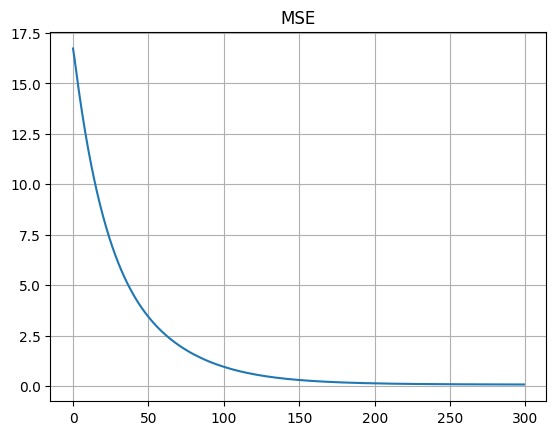

In [16]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

plt.title("MSE")
plt.plot(np.array(total_loss))
plt.grid()
plt.show()

In [28]:
a = network.W.weight
ba = network.b.weight

In [29]:
import pickle
with open(FOLDER/'Wname', 'wb') as f:
    pickle.dump(network.W.weight, f)
with open(FOLDER/'bname', 'wb') as f:
    pickle.dump(network.b.weight, f)

In [41]:
epochs = 300
total_loss = []
w_ = vdf.iloc[:, :300]
bias_ = vdf.iloc[:, 300]
name_c_idb, network_c = get_idb_network(nonname_in_name_context, w_, bias_)
optimizer = torch.optim.Adam(network_c.parameters(), lr=0.001)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_loop(network_c, torch.nn.MSELoss(), optimizer, name_c_idb)
    total_loss.append(loss)
print("Done!")

Epoch 1
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:23<00:00,  4.70it/s]


Epoch 2
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:30<00:00,  3.56it/s]


Epoch 3
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.42it/s]


Epoch 4
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.52it/s]


Epoch 5
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.78it/s]


Epoch 6
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.78it/s]


Epoch 7
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.85it/s]


Epoch 8
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.56it/s]


Epoch 9
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:23<00:00,  4.73it/s]


Epoch 10
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.08it/s]


Epoch 11
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:24<00:00,  4.48it/s]


Epoch 12
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.80it/s]


Epoch 13
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:23<00:00,  4.75it/s]


Epoch 14
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.91it/s]


Epoch 15
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.63it/s]


Epoch 16
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.49it/s]


Epoch 17
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.47it/s]


Epoch 18
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.94it/s]


Epoch 19
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.13it/s]


Epoch 20
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.85it/s]


Epoch 21
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.01it/s]


Epoch 22
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.29it/s]


Epoch 23
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.23it/s]


Epoch 24
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.15it/s]


Epoch 25
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.04it/s]


Epoch 26
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.23it/s]


Epoch 27
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.09it/s]


Epoch 28
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.34it/s]


Epoch 29
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.23it/s]


Epoch 30
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:23<00:00,  4.64it/s]


Epoch 31
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.87it/s]


Epoch 32
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:31<00:00,  3.50it/s]


Epoch 33
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:24<00:00,  4.55it/s]


Epoch 34
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.89it/s]


Epoch 35
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.09it/s]


Epoch 36
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:23<00:00,  4.65it/s]


Epoch 37
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.27it/s]


Epoch 38
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.31it/s]


Epoch 39
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.36it/s]


Epoch 40
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.89it/s]


Epoch 41
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.32it/s]


Epoch 42
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.33it/s]


Epoch 43
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.36it/s]


Epoch 44
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.25it/s]


Epoch 45
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.39it/s]


Epoch 46
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.34it/s]


Epoch 47
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.33it/s]


Epoch 48
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.24it/s]


Epoch 49
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.37it/s]


Epoch 50
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.45it/s]


Epoch 51
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.46it/s]


Epoch 52
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.41it/s]


Epoch 53
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.44it/s]


Epoch 54
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.44it/s]


Epoch 55
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.39it/s]


Epoch 56
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.34it/s]


Epoch 57
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.43it/s]


Epoch 58
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.44it/s]


Epoch 59
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.39it/s]


Epoch 60
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:23<00:00,  4.68it/s]


Epoch 61
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.33it/s]


Epoch 62
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:23<00:00,  4.75it/s]


Epoch 63
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.47it/s]


Epoch 64
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.43it/s]


Epoch 65
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.32it/s]


Epoch 66
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.36it/s]


Epoch 67
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.34it/s]


Epoch 68
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.42it/s]


Epoch 69
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.38it/s]


Epoch 70
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.43it/s]


Epoch 71
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.41it/s]


Epoch 72
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.46it/s]


Epoch 73
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.34it/s]


Epoch 74
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.43it/s]


Epoch 75
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.46it/s]


Epoch 76
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.31it/s]


Epoch 77
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.40it/s]


Epoch 78
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.88it/s]


Epoch 79
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.83it/s]


Epoch 80
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.85it/s]


Epoch 81
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.91it/s]


Epoch 82
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.87it/s]


Epoch 83
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 84
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 85
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.81it/s]


Epoch 86
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.87it/s]


Epoch 87
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.92it/s]


Epoch 88
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.86it/s]


Epoch 89
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.40it/s]


Epoch 90
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.85it/s]


Epoch 91
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.83it/s]


Epoch 92
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.35it/s]


Epoch 93
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.86it/s]


Epoch 94
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.83it/s]


Epoch 95
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.92it/s]


Epoch 96
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.85it/s]


Epoch 97
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.75it/s]


Epoch 98
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 99
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.86it/s]


Epoch 100
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 101
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.88it/s]


Epoch 102
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.67it/s]


Epoch 103
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.88it/s]


Epoch 104
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.77it/s]


Epoch 105
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.88it/s]


Epoch 106
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.85it/s]


Epoch 107
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.88it/s]


Epoch 108
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.85it/s]


Epoch 109
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.64it/s]


Epoch 110
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.74it/s]


Epoch 111
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.85it/s]


Epoch 112
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.85it/s]


Epoch 113
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 114
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.85it/s]


Epoch 115
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.80it/s]


Epoch 116
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.80it/s]


Epoch 117
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.82it/s]


Epoch 118
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.88it/s]


Epoch 119
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.85it/s]


Epoch 120
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.87it/s]


Epoch 121
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.85it/s]


Epoch 122
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.87it/s]


Epoch 123
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.82it/s]


Epoch 124
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.88it/s]


Epoch 125
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 126
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 127
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.86it/s]


Epoch 128
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.88it/s]


Epoch 129
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.81it/s]


Epoch 130
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 131
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 132
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.90it/s]


Epoch 133
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.86it/s]


Epoch 134
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.88it/s]


Epoch 135
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.83it/s]


Epoch 136
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.84it/s]


Epoch 137
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.87it/s]


Epoch 138
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 139
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.59it/s]


Epoch 140
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.83it/s]


Epoch 141
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.87it/s]


Epoch 142
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.80it/s]


Epoch 143
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 144
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.90it/s]


Epoch 145
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.86it/s]


Epoch 146
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.84it/s]


Epoch 147
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 148
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.91it/s]


Epoch 149
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.83it/s]


Epoch 150
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.92it/s]


Epoch 151
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.91it/s]


Epoch 152
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.88it/s]


Epoch 153
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 154
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 155
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.85it/s]


Epoch 156
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.87it/s]


Epoch 157
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.60it/s]


Epoch 158
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.91it/s]


Epoch 159
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.83it/s]


Epoch 160
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.81it/s]


Epoch 161
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.78it/s]


Epoch 162
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.88it/s]


Epoch 163
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.85it/s]


Epoch 164
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 165
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.84it/s]


Epoch 166
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.86it/s]


Epoch 167
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.83it/s]


Epoch 168
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.71it/s]


Epoch 169
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 170
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.85it/s]


Epoch 171
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.88it/s]


Epoch 172
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.84it/s]


Epoch 173
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.87it/s]


Epoch 174
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.72it/s]


Epoch 175
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.70it/s]


Epoch 176
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.88it/s]


Epoch 177
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.86it/s]


Epoch 178
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.87it/s]


Epoch 179
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.88it/s]


Epoch 180
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.86it/s]


Epoch 181
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 182
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 183
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.92it/s]


Epoch 184
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 185
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.85it/s]


Epoch 186
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 187
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.84it/s]


Epoch 188
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.88it/s]


Epoch 189
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.90it/s]


Epoch 190
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 191
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.91it/s]


Epoch 192
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:28<00:00,  3.83it/s]


Epoch 193
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.23it/s]


Epoch 194
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.09it/s]


Epoch 195
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.87it/s]


Epoch 196
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.25it/s]


Epoch 197
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.45it/s]


Epoch 198
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.33it/s]


Epoch 199
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.45it/s]


Epoch 200
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.48it/s]


Epoch 201
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.45it/s]


Epoch 202
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.25it/s]


Epoch 203
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.46it/s]


Epoch 204
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.29it/s]


Epoch 205
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.38it/s]


Epoch 206
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.39it/s]


Epoch 207
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.43it/s]


Epoch 208
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.23it/s]


Epoch 209
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.25it/s]


Epoch 210
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.88it/s]


Epoch 211
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.11it/s]


Epoch 212
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.40it/s]


Epoch 213
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.40it/s]


Epoch 214
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.41it/s]


Epoch 215
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.40it/s]


Epoch 216
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.42it/s]


Epoch 217
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  5.00it/s]


Epoch 218
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.37it/s]


Epoch 219
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.41it/s]


Epoch 220
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.47it/s]


Epoch 221
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.40it/s]


Epoch 222
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.46it/s]


Epoch 223
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.17it/s]


Epoch 224
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.44it/s]


Epoch 225
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.38it/s]


Epoch 226
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.44it/s]


Epoch 227
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.41it/s]


Epoch 228
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.39it/s]


Epoch 229
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.39it/s]


Epoch 230
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.33it/s]


Epoch 231
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.41it/s]


Epoch 232
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.95it/s]


Epoch 233
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.29it/s]


Epoch 234
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.40it/s]


Epoch 235
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.39it/s]


Epoch 236
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.36it/s]


Epoch 237
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.39it/s]


Epoch 238
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.36it/s]


Epoch 239
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.33it/s]


Epoch 240
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.38it/s]


Epoch 241
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.36it/s]


Epoch 242
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.37it/s]


Epoch 243
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.38it/s]


Epoch 244
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.20it/s]


Epoch 245
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.24it/s]


Epoch 246
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.39it/s]


Epoch 247
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.45it/s]


Epoch 248
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.35it/s]


Epoch 249
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.12it/s]


Epoch 250
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.31it/s]


Epoch 251
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.32it/s]


Epoch 252
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.44it/s]


Epoch 253
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.12it/s]


Epoch 254
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.32it/s]


Epoch 255
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.36it/s]


Epoch 256
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.34it/s]


Epoch 257
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.35it/s]


Epoch 258
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.37it/s]


Epoch 259
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.41it/s]


Epoch 260
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:21<00:00,  5.22it/s]


Epoch 261
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.39it/s]


Epoch 262
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.80it/s]


Epoch 263
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.80it/s]


Epoch 264
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:22<00:00,  4.81it/s]


Epoch 265
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.56it/s]


Epoch 266
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.65it/s]


Epoch 267
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.86it/s]


Epoch 268
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.84it/s]


Epoch 269
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.78it/s]


Epoch 270
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.85it/s]


Epoch 271
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 272
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.87it/s]


Epoch 273
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 274
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 275
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.79it/s]


Epoch 276
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.88it/s]


Epoch 277
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.90it/s]


Epoch 278
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.90it/s]


Epoch 279
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.87it/s]


Epoch 280
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.86it/s]


Epoch 281
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.81it/s]


Epoch 282
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.92it/s]


Epoch 283
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.91it/s]


Epoch 284
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.70it/s]


Epoch 285
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.95it/s]


Epoch 286
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.87it/s]


Epoch 287
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.80it/s]


Epoch 288
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.91it/s]


Epoch 289
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.90it/s]


Epoch 290
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.90it/s]


Epoch 291
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.91it/s]


Epoch 292
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.85it/s]


Epoch 293
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.88it/s]


Epoch 294
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:20<00:00,  5.43it/s]


Epoch 295
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 296
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.89it/s]


Epoch 297
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.93it/s]


Epoch 298
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.92it/s]


Epoch 299
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:18<00:00,  5.90it/s]


Epoch 300
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:19<00:00,  5.64it/s]

Done!


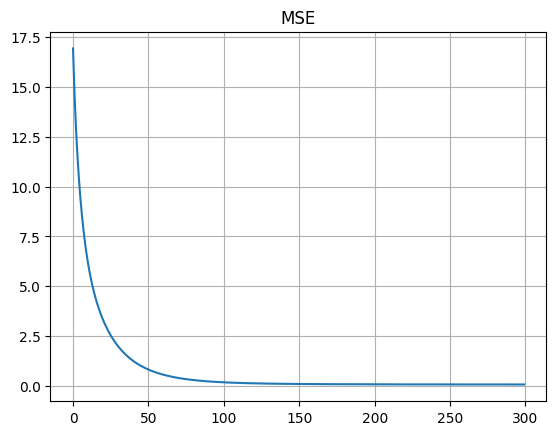

In [42]:
plt.title("MSE")
plt.plot(np.array(total_loss))
plt.grid()
plt.show()

In [47]:
total_loss[-1]

0.07618881372565572

In [43]:
import pickle
with open(FOLDER/'Wc_name', 'wb') as f:
    pickle.dump(network_c.W.weight, f)
with open(FOLDER/'bc_name', 'wb') as f:
    pickle.dump(network_c.b.weight, f)

In [71]:
name_only_nfs = sorted(list(set(name_nfs) - set(non_name_nfs)))
len(name_nfs), len(name_only_nfs)

(2141, 1025)

In [78]:
name_vecs = np.concatenate([network.W(torch.LongTensor(name_only_nfs)).detach().numpy(),
                            network.b(torch.LongTensor(name_only_nfs)).detach().numpy(),
                            network_c.W(torch.LongTensor(name_only_nfs)).detach().numpy(),
                            network_c.b(torch.LongTensor(name_only_nfs)).detach().numpy()], axis=1)
name_vecs.shape

(1025, 602)

In [103]:
nvdf = np.array(vdf.copy())
nvdf[name_only_nfs] = name_vecs
nvdf = pd.DataFrame(nvdf)

In [115]:
nvdf.to_csv(FOLDER/'name-glove-1.csv', sep='\t', encoding='utf-8')

In [3]:
from tg.grammar_ru import *
import pandas as pd

FOLDER = Loc.data_cache_path/'Rowling'

nvdf = pd.read_csv(FOLDER/'name-glove-1.csv', sep='\t')
nvdf = nvdf.iloc[:, 1:603]